## Rapport : Résolution de Problèmes / Machine Learning

#### IMT Mines Alès Octobre 2022
##### INFRES 13 
- **Quentin BIALOTA**
- **Alexandre BOMPUIS**
- **Julia LOCATELLI**
- **Tom L'HERMENIER**

![Logo IMT](https://www.fondation-mines-telecom.org/wp-content/uploads/2018/02/imt_mines_ales-300x158.jpg)

---

Dans le cadre de du cours de **ANN & Deep learning** à l'IMT Mines Alès, nous avons réalisé un projet de notre choix, visant à résoudre un problème de machine learning, le tout en évaluant et comparant quelques modèles pour la résolution du problème. Dans ce projet, nous avons choisi de traiter une problématique visant à prédire les vêtements qu'on peut observer dans une image donné. Cette prédiction se fera à partir de différentes caractéristiques, notamment le sexe de la personne sur l'image, les catégories du vêtement (vêtement, accessoire, etc), et d'autres.

---

Afin de traiter ce problème, nous avons décidé d'utiliser un dataset déjà existant et disponible sur le site Kaggle. Ce dataset nommé "Fashion Product Images" est accessible au lien suivant : https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

#### Imports globaux

Avant toutes choses, veuillez lancer la cellule suivante pour importer les librairies et les outils utilisés dans ce rapport

In [1]:
## Import everything needed

from IPython.display import display

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

#### Import dataset

Via la cellule suivante, vous pouvez importer le dataset en local (le dataset small est disponible [ici](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small?resource=download))

In [2]:
# Import dataset
df = pd.read_csv("fashion-dataset-small/styles.csv", on_bad_lines='skip')

#### Information sur le dataset

44000+ produits avec des étiquettes de catégorie et des images.

In [3]:
## Dataset visualization

# Show dataset size
display("Dataset size", df.shape[0])
# Show the first ten rows of the dataset
display("First ten rows of the dataset", df.head(10))
# Show number of subcategory
display(df.subCategory.value_counts())
# Show number of articleType in subcategory Topwear
display("Number of articleType in subcategory Topwear", df[df.subCategory == "Topwear"].articleType.value_counts())

'Dataset size'

44419

'First ten rows of the dataset'

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


Topwear                     15398
Shoes                        7343
Bags                         3055
Bottomwear                   2693
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care                      77
Skin          

'Number of articleType in subcategory Topwear'

Tshirts          7065
Shirts           3215
Kurtas           1844
Tops             1762
Sweatshirts       285
Sweaters          277
Jackets           258
Kurtis            234
Tunics            229
Dupatta           116
Suspenders         40
Rain Jacket        18
Waistcoat          15
Rompers            12
Blazers             8
Shrug               6
Nehru Jackets       5
Lehenga Choli       4
Belts               3
Dresses             2
Name: articleType, dtype: int64

##### Exemple d'une image contenu dans le dataset

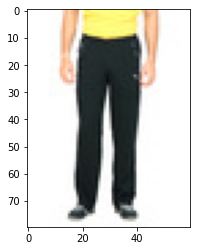

In [4]:
# Show an image of the dataset
image = cv2.imread("fashion-dataset-small/images/18000.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.cvtColor(image, cv2.COLOR_BGR5652GRAY)
plt.imshow(image)
plt.show()

#### Structure du dataset

Le dataset est composé de 10 caractéristiques (id, gender, masterCategory, subCategory, articleType, baseColour, season, year, usage, productDisplayName).

Afin d'effectuer la reconnaissance de vêtements, nous avons dû dans un premier temps sélectionner la caractéristique qu'on allait utiliser plus tard pour entrainer le modèle. Dans notre cas, nous avons choisi d'utiliser la caractéristique "subCategory" car elle disposait d'assez de classes avec au moins 500+ données labélisées par classe.

Ensuite, nous avons conservé que les classes qui correspondait à des vêtements / accessoires qui disposait de 500+ données labélisées, pour arriver à un total de 30848 données labélisées.

In [5]:
MIN_OCCURRENCE_NUMBER_BY_CLASSES = 200

# Drop subCategory that is not Topwear, Bottomwear, Shoes, Sandal, Bags, Flip Flops, Dress
df = df[df.subCategory.isin(["Topwear", "Bottomwear", "Shoes", "Sandal", "Bags", "Flip Flops", "Dress"])]

# Show dataset size with Topwear, Bottomwear, Shoes, Sandal, Bags, Flip Flops, Dress
display("Dataset size", df.shape[0])

# Show number of articleType
display(df['articleType'].unique())

# Get the list of articleType that have less than 100 occurences
df_2 = df['articleType'].value_counts()
l = df_2[df_2 < MIN_OCCURRENCE_NUMBER_BY_CLASSES].index.tolist()

# Remove from dataset row with articleType occurence less than 100
for article in l:
  df = df.loc[df['articleType'] != article]

CLASSES_NUMBER_OUTPUT = df['articleType'].shape[0]

'Dataset size'

30843

array(['Shirts', 'Jeans', 'Track Pants', 'Tshirts', 'Casual Shoes',
       'Flip Flops', 'Handbags', 'Tops', 'Sandals', 'Sweatshirts',
       'Formal Shoes', 'Flats', 'Kurtas', 'Waistcoat', 'Sports Shoes',
       'Shorts', 'Heels', 'Laptop Bag', 'Rain Jacket', 'Dresses',
       'Skirts', 'Blazers', 'Clutches', 'Shrug', 'Backpacks', 'Trousers',
       'Dupatta', 'Capris', 'Tunics', 'Jackets', 'Duffel Bag',
       'Sports Sandals', 'Sweaters', 'Trolley Bag', 'Tracksuits',
       'Swimwear', 'Leggings', 'Kurtis', 'Mobile Pouch', 'Messenger Bag',
       'Jumpsuit', 'Suspenders', 'Salwar and Dupatta', 'Patiala',
       'Stockings', 'Tights', 'Churidar', 'Tablet Sleeve',
       'Nehru Jackets', 'Salwar', 'Jeggings', 'Wallets', 'Rompers',
       'Waist Pouch', 'Rucksacks', 'Lehenga Choli', 'Belts',
       'Rain Trousers', 'Travel Accessory'], dtype=object)

In [6]:
## Data preprocessing

# For each articleType assign a number
df['articleTypeCode'] = df['articleType'].astype('category')
df['articleTypeCode'] = df['articleTypeCode'].cat.codes

# Get the articleTypeCode and the associated articleType ordered by articleTypeCode
article_type_dict = df[['articleTypeCode', 'articleType']].drop_duplicates().sort_values('articleTypeCode')
display("articleTypeCode and the associated articleType", article_type_dict)

'articleTypeCode and the associated articleType'

,articleTypeCode,articleType
145,0,Backpacks
10,1,Casual Shoes
135,2,Clutches
94,3,Dresses
34,4,Flats
12,5,Flip Flops
25,6,Formal Shoes
13,7,Handbags
76,8,Heels
257,9,Jackets


#### Instanciation du device

Afin d'obtenir de meilleures performances lors de l'entrainement et de l'évaluation des différents modèles, nous allons utiliser un GPU à l'aide de cuda.

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
print(device)

cuda:0


#### Classe illustrant le dataset

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms

# Create a class for the dataset with colors pictures
class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.copy()
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the image if the image exists
        try:
            image = cv2.imread("fashion-dataset-small/images/" + str(self.df.iloc[idx, 0]) + ".jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = np.zeros((224, 224, 3), np.uint8)

        # Get the label with the articleType
        label = self.df['articleTypeCode'].iloc[idx]
        
        # Transform the image
        if self.transform:
            image = self.transform(image)

        return image, label

#### Instantiation des set d'entrainements et de tests

In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    # Resize
    transforms.Resize((224, 224)),
    # To tensor
    transforms.ToTensor(),
    # Normalize
    transforms.Normalize((0.5,), (0.5,))
])

dataset = FashionDataset(df, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for batch_id, batch in enumerate(train_loader):
    images, labels  = batch
    if batch_id == 0:
        print(images.shape)
        print(labels)
        break

torch.Size([16, 3, 224, 224])
tensor([ 6,  5, 14, 22,  8, 19, 22, 19,  1, 13, 13,  8, 17,  5, 22,  9],
       dtype=torch.int8)


#### Fonction permettant l'enregistrement du model entrainé / le chargement du model entrainé

In [10]:
from pathlib import Path

def save_model_min(model, modelName, path):
    create_directory(modelName)
    torch.save(model.state_dict(), path)

def save_model(model, modelName, epoch, optimizer, path):
    create_directory(modelName)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def create_directory(modelName):
    Path("models").mkdir(parents=True, exist_ok=True)
    Path("models/{}".format(modelName)).mkdir(parents=True, exist_ok=True)

def load_model(model, path):
    model.load_state_dict(torch.load(path))

#### Fonction d'entrainement générique

In [11]:
import time

# Training function
def train_optim(model, _train_loader, _test_loader, epochs, log_frequency, device, modelName, batch_size, learning_rate=1e-4, show_items_accuracy = True):

  start_time = time.time()

  print("TRAIN&TEST on {} model | Number of epochs : {} | Batch size : {} | Log frequency : {} | Device : {}".format(modelName, epochs, batch_size, log_frequency, device))

  model.to(device) # we make sure the model is on the proper device

  # Multiclass classification setting, we use cross-entropy
  # note that this implementation requires the logits as input 
  # logits: values prior softmax transformation 
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  numberOfBatch = round(len(_train_loader.dataset) / batch_size)

  rates = []
  lossesValidation = []
  lossesTrain = []
  correct_dic = {}
  total_dic = {}
  for t in range(epochs):

      lossesTrainByBatch = []

      model.train() # we specify that we are training the model

      # At each epoch, the training set will be processed as a set of batches
      for batch_id,  batch in enumerate(_train_loader) : 

        images, labels  = batch
        labels = labels.type(torch.LongTensor)

        # we put the data on the same device
        images , labels = images.to(device), labels.to(device)  
        
        y_pred = model(images) # forward pass output=logits

        loss = loss_fn(y_pred, labels)

        lossesTrainByBatch.append(loss.item())

        if batch_id % log_frequency == 0:
          print("Epoch: {:03d} / {} | Batch: {:03d} / {} | Loss: {:.3f} | Time elapsed: {:.3f} s ".format(t+1, epochs, batch_id+1, numberOfBatch, loss.item(), (time.time() - start_time)))

        optimizer.zero_grad() # clear the gradient before backward
        loss.backward()       # update the gradient

        optimizer.step() # update the model parameters using the gradient

      lossesTrain.append((sum(lossesTrainByBatch))/len(lossesTrainByBatch))

      # Model evaluation after each step computing the accuracy
      with torch.no_grad():
        model.eval()
        total = 0
        correct = 0
        lossesValidationByBatch = []

        for batch_id, batch in enumerate(_test_loader):
          images , labels = batch
          labels = labels.type(torch.LongTensor)
          images , labels = images.to(device), labels.to(device)
          y_pred = model(images) # forward computes the logits

          lossesValidationByBatch.append(loss_fn(y_pred, labels).item())

          sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
          _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
          
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Calculation of the percentage of success of the prediction by classes
          i = 0
          for predict in predicted:
            isCorrect = predict.item() == labels[i].item()
            if(isCorrect):
              if labels[i].item() in correct_dic:
                correct_dic[labels[i].item()] += 1
              else:
                correct_dic[labels[i].item()] = 1
            
            if labels[i].item() in total_dic:
                total_dic[labels[i].item()] += 1
            else:
                total_dic[labels[i].item()] = 1
            i+=1
        
        if(show_items_accuracy):
          for article in article_type_dict.values:
            print("{} => occ:{}/{} | prc:{:.3f}%".format(article[1], correct_dic.get(article[0], 0), total_dic.get(article[0], 1), correct_dic.get(article[0], 0) / total_dic.get(article[0], 1) * 100))
        
        print("[Validation] Accuracy: {:.3f}%".format(100 * correct / total))
        rates.append(correct / total)

        print("[Validation] Loss (avg): {:.3f}\n".format((sum(lossesValidationByBatch))/len(lossesValidationByBatch)))
        lossesValidation.append((sum(lossesValidationByBatch))/len(lossesValidationByBatch))
        
        # Save the model after each epoch
        save_model_min(model, modelName, "models/{}/{}_{}.pt".format(modelName, modelName, t))
  
  # Show a summary chart of rates %
  plt.plot(np.arange(0, len(rates)), rates)
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.show()

  labelsBars = []
  percentageValues = []

  for article in article_type_dict.values:
    labelsBars.append(article[1])
    percentageValues.append(correct_dic.get(article[0], 0) / total_dic.get(article[0], 1) * 100)
  
  percentage_series = pd.Series(percentageValues)

  plt.figure(figsize=(12, 8))
  ax = percentage_series.plot(kind="bar")
  ax.set_title("Percentage of accuracy for each articleType of the testing dataset")
  ax.set_ylabel("Percentage of accuracy (%)")
  ax.set_xticklabels(labelsBars)
  plt.show()

  plt.plot(np.arange(0, len(lossesValidation)), lossesValidation, color='red', label='Loss validation')
  plt.ylabel("Loss value (avg)")
  plt.plot(np.arange(0, len(lossesTrain)), lossesTrain, color='green', label = 'Loss Train')
  plt.legend(loc = 'upper right')
  plt.show()

In [12]:
from torchvision import models

help(models)

def freeze_model(model):
  for param in model.parameters():
    param.requires_grad = False

def unfreeze_model(model):
  for param in model.parameters():
    param.requires_grad = True

Help on package torchvision.models in torchvision:

NAME
    torchvision.models

PACKAGE CONTENTS
    _api
    _meta
    _utils
    alexnet
    convnext
    densenet
    detection (package)
    efficientnet
    feature_extraction
    googlenet
    inception
    mnasnet
    mobilenet
    mobilenetv2
    mobilenetv3
    optical_flow (package)
    quantization (package)
    regnet
    resnet
    segmentation (package)
    shufflenetv2
    squeezenet
    swin_transformer
    vgg
    video (package)
    vision_transformer

FILE
    c:\users\quent\appdata\local\programs\python\python310\lib\site-packages\torchvision\models\__init__.py




#### **Modèle : ResNet18**

##### Architecture :

![resnet-18-architecture](https://penseeartificielle.fr/wp-content/uploads/2019/01/Proposed-Modified-ResNet-18-architecture-for-Bangla-HCR-In-the-diagram-conv-stands-for.jpg)

*(source : https://penseeartificielle.fr/focus-reseau-neurones-convolutifs/proposed-modified-resnet-18-architecture-for-bangla-hcr-in-the-diagram-conv-stands-for/)*

TRAIN&TEST on ResNet18 model | Number of epochs : 10 | Batch size : 16 | Log frequency : 200 | Device : cuda:0
Epoch: 001 / 10 | Batch: 001 / 1477 | Loss: 10.340 | Time elapsed: 0.282 s 
Epoch: 001 / 10 | Batch: 201 / 1477 | Loss: 2.288 | Time elapsed: 10.360 s 
Epoch: 001 / 10 | Batch: 401 / 1477 | Loss: 1.174 | Time elapsed: 20.423 s 
Epoch: 001 / 10 | Batch: 601 / 1477 | Loss: 0.906 | Time elapsed: 29.870 s 
Epoch: 001 / 10 | Batch: 801 / 1477 | Loss: 0.999 | Time elapsed: 39.590 s 
Epoch: 001 / 10 | Batch: 1001 / 1477 | Loss: 1.418 | Time elapsed: 49.071 s 
Epoch: 001 / 10 | Batch: 1201 / 1477 | Loss: 1.407 | Time elapsed: 59.361 s 
Epoch: 001 / 10 | Batch: 1401 / 1477 | Loss: 1.548 | Time elapsed: 69.041 s 
[Validation] Accuracy: 70.232%
[Validation] Loss (avg): 0.918

Epoch: 002 / 10 | Batch: 001 / 1477 | Loss: 0.651 | Time elapsed: 91.070 s 
Epoch: 002 / 10 | Batch: 201 / 1477 | Loss: 0.712 | Time elapsed: 101.387 s 
Epoch: 002 / 10 | Batch: 401 / 1477 | Loss: 0.696 | Time elaps

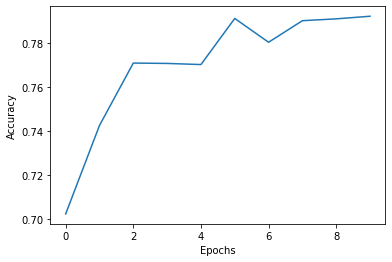

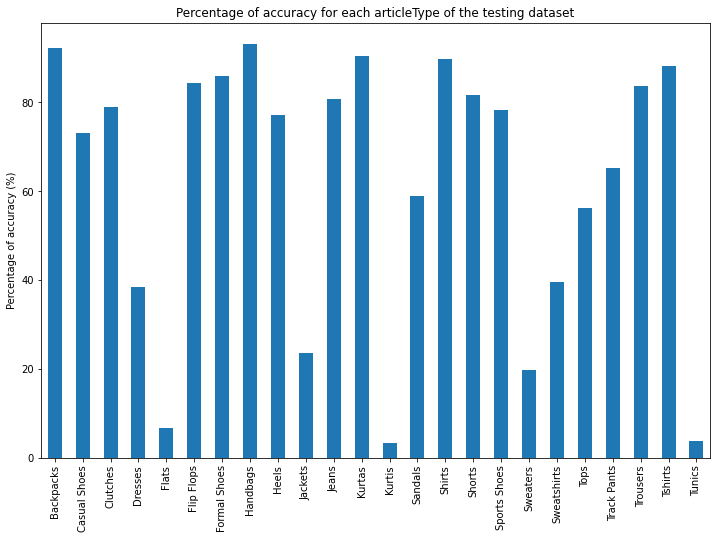

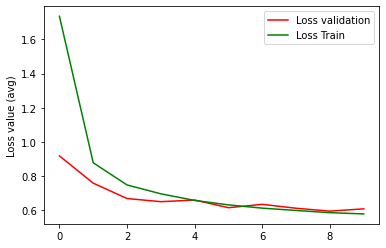

In [68]:
### A QUENTIN PAS TOUCHE

##########################################
MODEL_NAME = "ResNet18"
ETA = 1e-4 # Learning rate
EPOCHS = 10 # Epochs / Number of iteration
LOGS = 200 # Log Frequency
BATCH_SIZE = 16 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
###########################################################################################

### RESNET 18

resnet18 = models.resnet18()
resnet18_pretrained = models.resnet18(weights="ResNet18_Weights.DEFAULT")

freeze_model(resnet18_pretrained)

dataset_resnet18 = FashionDataset(df, transform=transform)

train_size_resnet18 = int(0.8 * len(dataset_resnet18))
test_size_resnet18 = len(dataset_resnet18) - train_size_resnet18
train_dataset_resnet18, test_dataset_resnet18 = random_split(dataset_resnet18, [train_size_resnet18, test_size_resnet18])
train_loader_resnet18 = DataLoader(train_dataset_resnet18, batch_size=BATCH_SIZE, shuffle=True)
test_loader_resnet18 = DataLoader(test_dataset_resnet18, batch_size=BATCH_SIZE, shuffle=True)

resnet18_pretrained.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.Linear(256, 128),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)

# Train
train_optim(resnet18_pretrained, train_loader_resnet18, test_loader_resnet18, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA, False)

#### **Model ResNet50**

##### Architecture :

![resnet-50-architecture](https://miro.medium.com/max/828/0*9LqUp7XyEx1QNc6A.png)

*(source : https://blog.devgenius.io/resnet50-6b42934db431)*

TRAIN&TEST on ResNet50 model | Number of epochs : 7 | Batch size : 16 | Log frequency : 200 | Device : cuda:0
Epoch: 001 / 7 | Batch: 001 / 1477 | Loss: 10.329 | Time elapsed: 7.338 s 
Epoch: 001 / 7 | Batch: 201 / 1477 | Loss: 1.389 | Time elapsed: 21.938 s 
Epoch: 001 / 7 | Batch: 401 / 1477 | Loss: 0.937 | Time elapsed: 36.377 s 
Epoch: 001 / 7 | Batch: 601 / 1477 | Loss: 1.265 | Time elapsed: 51.331 s 
Epoch: 001 / 7 | Batch: 801 / 1477 | Loss: 1.136 | Time elapsed: 68.147 s 
Epoch: 001 / 7 | Batch: 1001 / 1477 | Loss: 0.747 | Time elapsed: 83.545 s 
Epoch: 001 / 7 | Batch: 1201 / 1477 | Loss: 1.274 | Time elapsed: 98.701 s 
Epoch: 001 / 7 | Batch: 1401 / 1477 | Loss: 0.714 | Time elapsed: 114.614 s 
Backpacks => occ:115/143 | prc:80.420%
Casual Shoes => occ:414/551 | prc:75.136%
Clutches => occ:9/55 | prc:16.364%
Dresses => occ:7/101 | prc:6.931%
Flats => occ:0/92 | prc:0.000%
Flip Flops => occ:157/197 | prc:79.695%
Formal Shoes => occ:79/133 | prc:59.398%
Handbags => occ:355/366 

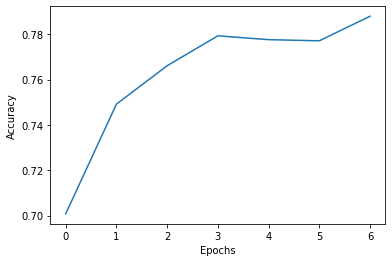

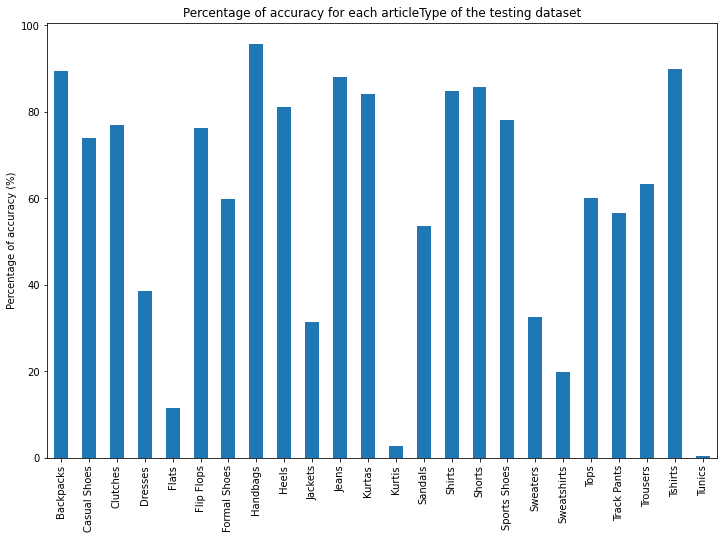

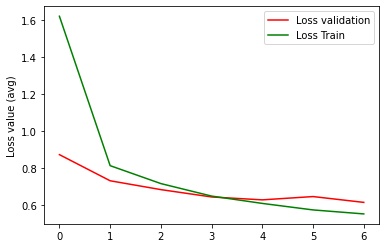

In [13]:
### A TOM PAS TOUCHE

##########################################
MODEL_NAME = "ResNet50"
ETA = 1e-4 # Learning rate
EPOCHS = 7 # Epochs / Number of iteration
LOGS = 200 # Log Frequency
BATCH_SIZE = 16 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
###########################################################################################

### RESNET 50
resnet50 = models.resnet50()
resnet50_pretained = models.resnet50(weights="ResNet50_Weights.DEFAULT")

freeze_model(resnet50_pretained)

dataset_resnet50 = FashionDataset(df, transform=transform)

train_size_resnet50 = int(0.8 * len(dataset_resnet50))
test_size_resnet50 = len(dataset_resnet50) - train_size_resnet50
train_dataset_resnet50, test_dataset_resnet50 = random_split(dataset_resnet50, [train_size_resnet50, test_size_resnet50])
train_loader_resnet50 = DataLoader(train_dataset_resnet50, batch_size=BATCH_SIZE, shuffle=True)
test_loader_resnet50 = DataLoader(test_dataset_resnet50, batch_size=BATCH_SIZE, shuffle=True)

# Change on resnet50 model to fit our dataset
#resnet50.fc = torch.nn.Linear(2048, 60)

resnet50_pretained.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 1024),
    torch.nn.Linear(1024, 512),
    torch.nn.Linear(512, 256),
    torch.nn.Linear(256, 128),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)

# Train
train_optim(resnet50_pretained, train_loader_resnet50, test_loader_resnet50, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA)

#### **Model AlexNet**

##### Architecture :

![alexnet-architecture](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/alexnet2.png)

*(source : https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide/notebook)*

TRAIN&TEST on AlexNet model | Number of epochs : 7 | Batch size : 16 | Log frequency : 200 | Device : cuda:0
Epoch: 001 / 7 | Batch: 001 / 1542 | Loss: 4.092 | Time elapsed: 0.263 s 
Epoch: 001 / 7 | Batch: 201 / 1542 | Loss: 2.164 | Time elapsed: 10.429 s 
Epoch: 001 / 7 | Batch: 401 / 1542 | Loss: 1.503 | Time elapsed: 20.624 s 
Epoch: 001 / 7 | Batch: 601 / 1542 | Loss: 1.441 | Time elapsed: 31.948 s 
Epoch: 001 / 7 | Batch: 801 / 1542 | Loss: 1.804 | Time elapsed: 43.216 s 
Epoch: 001 / 7 | Batch: 1001 / 1542 | Loss: 1.099 | Time elapsed: 54.472 s 
Epoch: 001 / 7 | Batch: 1201 / 1542 | Loss: 1.089 | Time elapsed: 65.215 s 
Epoch: 001 / 7 | Batch: 1401 / 1542 | Loss: 1.388 | Time elapsed: 76.354 s 
[Validation] Accuracy: 68.963%
[Validation] Loss (avg): 0.911

Epoch: 002 / 7 | Batch: 001 / 1542 | Loss: 1.585 | Time elapsed: 103.301 s 
Epoch: 002 / 7 | Batch: 201 / 1542 | Loss: 0.843 | Time elapsed: 113.657 s 
Epoch: 002 / 7 | Batch: 401 / 1542 | Loss: 0.442 | Time elapsed: 124.689 s

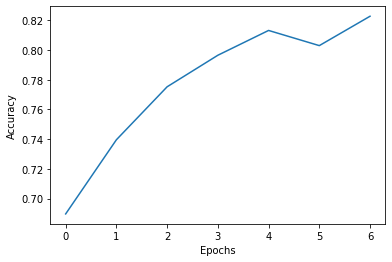

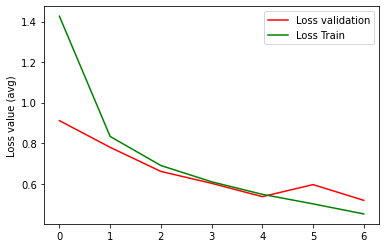

<Figure size 432x288 with 0 Axes>

In [17]:
##########################################
MODEL_NAME = "AlexNet"
ETA = 1e-4 # Learning rate
EPOCHS = 7 # Epochs / Number of iteration
LOGS = 200 # Log Frequency
BATCH_SIZE = 16 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
###########################################################################################

### AlexNet
alexnet = models.alexnet()
alexnet_pretrained = models.alexnet(weights="AlexNet_Weights.DEFAULT")

# Resize the images to 256x256
transform_alexnet = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_alexnet = FashionDataset(df, transform=transform)

train_size_alexnet = int(0.8 * len(dataset_alexnet))
test_size_alexnet = len(dataset_alexnet) - train_size_alexnet
train_dataset_alexnet, test_dataset_alexnet = random_split(dataset_alexnet, [train_size_alexnet, test_size_alexnet])
train_loader_alexnet = DataLoader(train_dataset_alexnet, batch_size=16, shuffle=True)
test_loader_alexnet = DataLoader(test_dataset_alexnet, batch_size=16, shuffle=True)

# Change on alexnet model to fit our dataset
alexnet.features = torch.nn.Sequential(*list(alexnet.features.children())[:-1])
alexnet.classifier[6] = torch.nn.Linear(4096, CLASSES_NUMBER_OUTPUT)

# Change on alexnet_pretrained model to fit our dataset
alexnet_pretrained.features = torch.nn.Sequential(*list(alexnet.features.children())[:-1])
alexnet_pretrained.classifier[6] = torch.nn.Linear(4096, CLASSES_NUMBER_OUTPUT)

# Train
train_optim(alexnet, train_loader_alexnet, test_loader_alexnet, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA)

In [ ]:
#Pretained
train_optim(alexnet_pretrained, train_loader_alexnet, test_loader_alexnet, EPOCHS, LOGS, device, "{}_pretrained".format(MODEL_NAME), BATCH_SIZE, ETA)

#### **Model LeNet5**

##### Architecture :

![letnet-5-architecture](https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg)

*(source : https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/)*

TRAIN&TEST on LeNet5 model | Number of epochs : 10 | Batch size : 32 | Log frequency : 200 | Device : cuda:0
Epoch: 001 / 10 | Batch: 001 / 771 | Loss: 4.069 | Time elapsed: 0.350 s 
Epoch: 001 / 10 | Batch: 201 / 771 | Loss: 2.631 | Time elapsed: 20.364 s 
Epoch: 001 / 10 | Batch: 401 / 771 | Loss: 1.616 | Time elapsed: 40.627 s 
Epoch: 001 / 10 | Batch: 601 / 771 | Loss: 1.941 | Time elapsed: 60.991 s 
[Validation] Accuracy: 55.154%
[Validation] Loss (avg): 1.592

Epoch: 002 / 10 | Batch: 001 / 771 | Loss: 1.461 | Time elapsed: 97.859 s 
Epoch: 002 / 10 | Batch: 201 / 771 | Loss: 1.444 | Time elapsed: 120.419 s 
Epoch: 002 / 10 | Batch: 401 / 771 | Loss: 1.583 | Time elapsed: 146.299 s 
Epoch: 002 / 10 | Batch: 601 / 771 | Loss: 1.208 | Time elapsed: 171.392 s 
[Validation] Accuracy: 61.394%
[Validation] Loss (avg): 1.244

Epoch: 003 / 10 | Batch: 001 / 771 | Loss: 1.133 | Time elapsed: 214.948 s 
Epoch: 003 / 10 | Batch: 201 / 771 | Loss: 0.949 | Time elapsed: 239.626 s 
Epoch: 003 

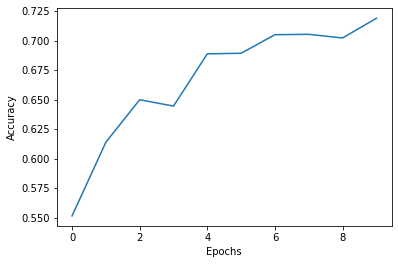

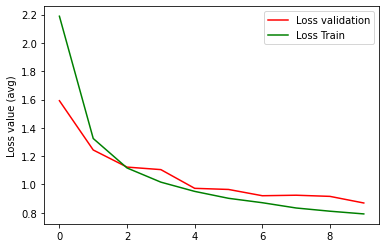

<Figure size 432x288 with 0 Axes>

In [15]:
##A titre d'exemple
import torch
import torch.nn.functional as F

##########################################
MODEL_NAME = "LeNet5"
ETA = 1e-4 # Learning rate
EPOCHS = 10 # Epochs / Number of iteration
LOGS = 200 # Log Frequency
BATCH_SIZE = 32 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
###########################################################################################

### LE NET 5
class LeNet5(torch.nn.Module):

  def __init__(self, D_out):

    super(LeNet5, self).__init__()
    self.name = "LeNet5"

    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(224,224), stride=1, padding=2)
    self.avgPool1 = torch.nn.AvgPool2d(kernel_size=(2,2), stride=2)
    self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2,2), stride=1)
    self.avgPool2 = torch.nn.AvgPool2d(kernel_size=(1,1), stride=2)
    self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1), stride=1) 
    self.flatten = torch.nn.Flatten()

    self.linear1 = torch.nn.Linear(64, 84)
    self.linear2 = torch.nn.Linear(84, 42)
    self.linear3 = torch.nn.Linear(42, 21 )
    self.linear4 = torch.nn.Linear( 21, D_out) 
  
  def forward(self, x):
      
    x = F.relu(self.conv1(x)) 
    x = self.avgPool1(x)
    x = F.relu( self.conv2(x) )
    x = self.avgPool2(x)
    x = F.relu( self.conv3(x) )
    x = self.flatten(x)
    x = F.relu( self.linear1(x) )
    x = F.relu( self.linear2(x) )
    x = F.relu( self.linear3(x) )
    x = self.linear4(x)
    
    return x

transform_lenet5 = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

#dataset_lenet5 = FashionDataset(df, transform=transform_lenet5)
dataset_lenet5 = FashionDataset(df, transform=transform)

train_size_lenet5 = int(0.8 * len(dataset_lenet5))
test_size_lenet5 = len(dataset_lenet5) - train_size_lenet5
train_dataset_lenet5, test_dataset_lenet5 = random_split(dataset_lenet5, [train_size_lenet5, test_size_lenet5])
train_loader_lenet5 = DataLoader(train_dataset_lenet5, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lenet5 = DataLoader(test_dataset_lenet5, batch_size=BATCH_SIZE, shuffle=True)

model_lenet5 = LeNet5(CLASSES_NUMBER_OUTPUT)

train_optim(model_lenet5, train_loader_lenet5, test_loader_lenet5, EPOCHS, LOGS, device,MODEL_NAME,BATCH_SIZE,ETA)

#### **Model Regnet_y_128gf**

##### Architecture :

![regnet-y-128gf-architecture](https://www.researchgate.net/profile/Dan-Casas-2/publication/321513796/figure/fig3/AS:629006114254853@1526978152796/Architecture-of-RegNet-While-only-ResNet-and-conv-are-trainable-errors-are-still.png)

*(source : https://www.researchgate.net/figure/Architecture-of-RegNet-While-only-ResNet-and-conv-are-trainable-errors-are-still_fig3_321513796)*

In [ ]:
from torch.utils import data
##########################################
MODEL_NAME = "Regnet_y_128gf"
ETA = 1e-4 # Learning rate
EPOCHS = 2 # Epochs / Number of iteration
LOGS = 20 # Log Frequency
BATCH_SIZE = 4 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
display("Used device : {}".format(device))
###########################################################################################

###Regnet_y_128gf
regnet_y_128gf = models.regnet_y_128gf()
regnet_y_128gf_pretrained = models.regnet_y_128gf(weights="RegNet_Y_128GF_Weights.DEFAULT")

dataset_regnet_y_128gf = FashionDataset(df, transform=transform)

train_size_regnet_y_128gf = int(0.8*len(dataset_regnet_y_128gf))
test_size_regnet_y_128gf = len(dataset_regnet_y_128gf)-train_size_regnet_y_128gf
train_dataset_regnet_y_128gf, test_dataset_regnet_y_128gf = random_split(dataset_regnet_y_128gf, [train_size_regnet_y_128gf, test_size_regnet_y_128gf])
train_loader_regnet_y_128gf = DataLoader(train_dataset_regnet_y_128gf, batch_size=BATCH_SIZE,shuffle=True)
test_loader_regnet_y_128gf = DataLoader(test_dataset_regnet_y_128gf, batch_size=BATCH_SIZE,shuffle=True)

regnet_y_128gf.fc = torch.nn.Sequential(
    torch.nn.Linear(7392, 1024),
    torch.nn.Linear(1024, 512),
    torch.nn.Linear(512, 256),
    torch.nn.Linear(256, 128),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)

train_optim(regnet_y_128gf, train_loader_regnet_y_128gf, test_loader_regnet_y_128gf, EPOCHS, LOGS, device, MODEL_NAME,BATCH_SIZE,ETA)

In [ ]:
#Pretrained
train_optim(regnet_y_128gf, train_loader_regnet_y_128gf, test_loader_regnet_y_128gf, EPOCHS, LOGS, device, "{}_pretrained".format(MODEL_NAME),BATCH_SIZE,ETA)

#### **Model CNN Multi Label**

##### Architecture :

In [ ]:
df['articleTypeCode'] = df['articleType'].astype('category')
df['articleTypeCode'] = df['articleTypeCode'].cat.codes

df['baseColourCode'] = df['baseColour'].astype('category')
df['baseColourCode'] = df['baseColourCode'].cat.codes

df['genderCode'] = df['gender'].astype('category')
df['genderCode'] = df['genderCode'].cat.codes

df['subCategoryCode'] = df['subCategory'].astype('category')
df['subCategoryCode'] = df['subCategoryCode'].cat.codes

In [ ]:
class CNNMLFashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.copy()
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the image if the image exists
        try:
            image = cv2.imread("fashion-dataset-small/images/" + str(self.df.iloc[idx, 0]) + ".jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = np.zeros((224, 224, 3), np.uint8)

        # Get the label with the articleType
        label_articleTypeCode = self.df['articleTypeCode'].iloc[idx]
        label_genderCode = self.df['genderCode'].iloc[idx]
        label_baseColourCode = self.df['baseColourCode'].iloc[idx]
        label_subCategoryCode = self.df['subCategoryCode'].iloc[idx]

        
        # Transform the image
        if self.transform:
            image = self.transform(image)

        return image, label_articleTypeCode, label_genderCode, label_baseColourCode, label_subCategoryCode

In [ ]:
import time

# Training function
def train_optim(model, _train_loader, _test_loader, epochs, log_frequency, device, modelName, batch_size, learning_rate=1e-4, show_items_accuracy = True):

  start_time = time.time()

  print("TRAIN&TEST on {} model | Number of epochs : {} | Batch size : {} | Log frequency : {} | Device : {}".format(modelName, epochs, batch_size, log_frequency, device))

  model.to(device) # we make sure the model is on the proper device

  # Multiclass classification setting, we use cross-entropy
  # note that this implementation requires the logits as input 
  # logits: values prior softmax transformation 
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  numberOfBatch = round(len(_train_loader.dataset) / batch_size)

  rates = []
  lossesValidation = []
  lossesTrain = []
  correct_dic = {}
  total_dic = {}
  for t in range(epochs):

      lossesTrainByBatch = []

      model.train() # we specify that we are training the model

      # At each epoch, the training set will be processed as a set of batches
      for batch_id,  batch in enumerate(_train_loader) : 

        images, labels  = batch
        labels = labels.type(torch.LongTensor)

        # we put the data on the same device
        images , labels = images.to(device), labels.to(device)  
        
        y_pred = model(images) # forward pass output=logits

        loss = loss_fn(y_pred, labels)

        lossesTrainByBatch.append(loss.item())

        if batch_id % log_frequency == 0:
          print("Epoch: {:03d} / {} | Batch: {:03d} / {} | Loss: {:.3f} | Time elapsed: {:.3f} s ".format(t+1, epochs, batch_id+1, numberOfBatch, loss.item(), (time.time() - start_time)))

        optimizer.zero_grad() # clear the gradient before backward
        loss.backward()       # update the gradient

        optimizer.step() # update the model parameters using the gradient

      lossesTrain.append((sum(lossesTrainByBatch))/len(lossesTrainByBatch))

      # Model evaluation after each step computing the accuracy
      with torch.no_grad():
        model.eval()
        total = 0
        correct = 0
        lossesValidationByBatch = []

        for batch_id, batch in enumerate(_test_loader):
          images , labels = batch
          labels = labels.type(torch.LongTensor)
          images , labels = images.to(device), labels.to(device)
          y_pred = model(images) # forward computes the logits

          lossesValidationByBatch.append(loss_fn(y_pred, labels).item())

          sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
          _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
          
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Calculation of the percentage of success of the prediction by classes
          i = 0
          for predict in predicted:
            isCorrect = predict.item() == labels[i].item()
            if(isCorrect):
              if labels[i].item() in correct_dic:
                correct_dic[labels[i].item()] += 1
              else:
                correct_dic[labels[i].item()] = 1
            
            if labels[i].item() in total_dic:
                total_dic[labels[i].item()] += 1
            else:
                total_dic[labels[i].item()] = 1
            i+=1
        
        if(show_items_accuracy):
          for article in article_type_dict.values:
            print("{} => occ:{}/{} | prc:{:.3f}%".format(article[1], correct_dic.get(article[0], 0), total_dic.get(article[0], 1), correct_dic.get(article[0], 0) / total_dic.get(article[0], 1) * 100))
        
        print("[Validation] Accuracy: {:.3f}%".format(100 * correct / total))
        rates.append(correct / total)

        print("[Validation] Loss (avg): {:.3f}\n".format((sum(lossesValidationByBatch))/len(lossesValidationByBatch)))
        lossesValidation.append((sum(lossesValidationByBatch))/len(lossesValidationByBatch))
        
        # Save the model after each epoch
        save_model_min(model, modelName, "models/{}/{}_{}.pt".format(modelName, modelName, t))
  
  # Show a summary chart of rates %
  plt.plot(np.arange(0, len(rates)), rates)
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.show()

  labelsBars = []
  percentageValues = []

  for article in article_type_dict.values:
    labelsBars.append(article[1])
    percentageValues.append(correct_dic.get(article[0], 0) / total_dic.get(article[0], 1) * 100)
  
  percentage_series = pd.Series(percentageValues)

  plt.figure(figsize=(12, 8))
  ax = percentage_series.plot(kind="bar")
  ax.set_title("Percentage of accuracy for each articleType of the testing dataset")
  ax.set_ylabel("Percentage of accuracy (%)")
  ax.set_xticklabels(labelsBars)
  plt.show()

  plt.plot(np.arange(0, len(lossesValidation)), lossesValidation, color='red', label='Loss validation')
  plt.ylabel("Loss value (avg)")
  plt.plot(np.arange(0, len(lossesTrain)), lossesTrain, color='green', label = 'Loss Train')
  plt.legend(loc = 'upper right')
  plt.show()

In [ ]:
##########################################
MODEL_NAME = "CNN MultiOuput"
ETA = 1e-4 # Learning rate
EPOCHS = 2 # Epochs / Number of iteration
LOGS = 20 # Log Frequency
BATCH_SIZE = 16 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
display("Used device : {}".format(device))
###########################################################################################

#Pytorch Branches
class Branch(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Branch, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.linear(x)
        return x

class ResNet50MultiOutput(torch.nn.Module):
    def __init__(self, D_out):
        super(ResNet50MultiOutput, self).__init__()
        self.name = "ResNet50MultiOutput"
        #self.lenet5 = LeNet5(D_out)
        self.resnet50 = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        self.branch_articleTypeCode = Branch(64, 8)
        self.branch_genderCode = Branch(64, 2)
        self.branch_baseColourCode = Branch(64, 11)
        self.branch_subCategoryCode = Branch(64, 15)

        self.resnet50.fc = torch.nn.Sequential(''
            self.branch_articleTypeCode,
            self.branch_genderCode,
            self.branch_baseColourCode,
            self.branch_subCategoryCode,
        )

    def forward(self, x):
        x = self.resnet50(x)
        articleTypeCode = self.branch_articleTypeCode(x)
        genderCode = self.branch_genderCode(x)
        baseColourCode = self.branch_baseColourCode(x)
        subCategoryCode = self.branch_subCategoryCode(x)
        
        return articleTypeCode, genderCode, baseColourCode, subCategoryCode, x


